# Deconvolution of bulk RNAseq

In [1]:
# Load libraries
library(DWLS)
library(dplyr)
library(data.table)
library(pheatmap)
library(ggplotify)
library(purrr)
library(ggpubr)
library(MatrixGenerics)
library(ggh4x)
library(RColorBrewer)
library(stringr)
library(Seurat)
library(edgeR) # v3.38.4
library(pheatmap)
library(data.table)
library(dplyr)
library(tidyverse)
library(ggalluvial)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: ggplot2

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges,

# Deconvolution of Macaque organoids with Macaque Single cell 

## Step 1 : Load single single-nuclei signatures

In [2]:
## Read the signature file for Mouse Pseudopregnant 
species = "Macaque"
load(paste0("../../../results/snRNA-seq/DWLS_", species,"/DWLS_", species,".RData"))

In [3]:
head(Signature)

Stromal  Epithelial_Glandular Stromal_Perivascular Myometrium
ALDH1A2 2.531987 0.07045426           0.06969982           0.11361348
SLC26A7 2.287229 0.07010433           0.07104918           0.08985287
RORB    2.647148 0.08610324           0.63499769           0.45319812
ANO4    2.272332 0.06671580           0.44015355           0.60258576
ALDH1A3 1.467016 0.02630625           0.00000000           0.11114578
EPHB1   2.503543 0.08887889           0.00000000           0.70574555
        Epithelial_Proliferating Endothelial Immune   
ALDH1A2 0.2253065                0.2867339   0.5884842
SLC26A7 0.2181458                0.2084128   0.5957193
RORB    0.2358075                0.2422649   0.7921006
ANO4    0.2264862                0.1724824   0.6585947
ALDH1A3 0.1014824                0.1904462   0.2875714
EPHB1   0.2495646                0.4354264   0.4142146

### Hormonise gene symbols and gene ID for the bulk expression matrix using Ensembl gene annotation 

In [10]:
### Signature has gene names in gene symbols (default for Seurat matrix)
### We change those ID to ENSID for better comparison to bulk
### We use the GTF of Ensembl of the same genome version as RNAseq for gene ID to ENSID conversion 

Gene_annotation = fread(paste0("../../../data/genename/", species, "_ensembl108_geneID_geneName.tab.txt"))
head(Gene_annotation)

### Add col for GeneID
Signature_ENSID = Signature %>% as.data.frame() %>% mutate("Gene name" = row.names(Signature))

### Add col for ENSID
Signature_ENSID = left_join(Signature_ENSID, Gene_annotation, by = "Gene name")
Signature_ENSID = Signature_ENSID %>% filter(`Gene stable ID` != "NA")

### Change rownames to ENSID
row.names(Signature_ENSID) = Signature_ENSID$`Gene stable ID`
Signature_ENSID = Signature_ENSID %>% select(-"Gene name", -"Gene stable ID")
head(Signature_ENSID)

### Save this signature with ENSID
write.table(Signature_ENSID, file = paste0("../../../results/snRNA-seq/DWLS_", species,"/DWLS_Signature_", species,".tsv"))
Signature_ENSID = as.matrix(Signature_ENSID)


Gene stable ID     Gene name
1 ENSMFAG00000055330          
2 ENSMFAG00000052166          
3 ENSMFAG00000048966          
4 ENSMFAG00000056376          
5 ENSMFAG00000063704          
6 ENSMFAG00000065171

Stromal  Epithelial_Glandular Stromal_Perivascular
ENSMFAG00000037327 2.531987 0.07045426           0.06969982          
ENSMFAG00000000973 2.287229 0.07010433           0.07104918          
ENSMFAG00000046226 2.647148 0.08610324           0.63499769          
ENSMFAG00000036524 2.272332 0.06671580           0.44015355          
ENSMFAG00000041683 1.467016 0.02630625           0.00000000          
ENSMFAG00000002358 2.503543 0.08887889           0.00000000          
                   Myometrium Epithelial_Proliferating Endothelial Immune   
ENSMFAG00000037327 0.11361348 0.2253065                0.2867339   0.5884842
ENSMFAG00000000973 0.08985287 0.2181458                0.2084128   0.5957193
ENSMFAG00000046226 0.45319812 0.2358075                0.2422649   0.7921006
ENSMFAG00000036524 0.60258576 0.2264862                0.1724824   0.6585947
ENSMFAG00000041683 0.11114578 0.1014824                0.1904462   0.2875714
ENSMFAG00000002358 0.70574555 0.2495646                0.4354264   0.4142146

## Step 2 : Bulk RNAseq data 

The bulk RNA seq data must have Gene names or ENS ID matching the genes ID from the single-nuclei data. 
Data must be normalised before using it for deconvolution (CPM - or other normalisation). 

Here we use RPKM normalised data

In [29]:
nrow(Signature)

[1] 354

In [11]:
species = "Macaque"

COUNTS = read.csv(paste0("../../../results/RNA-seq/countmatrix_normalised/", species,"_organoid_countmatrix_batchCorrected_logRPKM.tsv"),header=T,sep = "\t",row.names=1)

In [12]:
head(COUNTS)


TME2112.M.E2.T TME2112.M.E2.C TME2112.M.P4.T TME2112.M.P4.C
ENSMFAG00000000025 2.63681650     3.09419147     1.611239       2.74122550    
ENSMFAG00000000028 0.17006154     0.13426060     0.000000       0.02973256    
ENSMFAG00000000029 0.00000000     0.00000000     0.000000       0.00000000    
ENSMFAG00000000034 0.09358873     0.05545405     0.000000       0.20237823    
ENSMFAG00000000036 2.79741075     1.02316695     2.264508       1.16867978    
ENSMFAG00000000037 5.48744562     5.72327487     5.833698       5.52045461    
                   EMALP05.M.E2.T EMALP05.M.E2.C EMALP05.M.P4.T EMALP05.M.P4.C
ENSMFAG00000000025 3.1264504      2.785624       1.73091483     2.368031      
ENSMFAG00000000028 0.0000000      0.000000       0.07945945     0.000000      
ENSMFAG00000000029 0.0714076      0.000000       0.19096231     0.297786      
ENSMFAG00000000034 0.0000000      0.000000       0.19610233     0.000000      
ENSMFAG00000000036 2.5688411      1.206488       2.61516998     0.967114      
ENSMFAG00000000037 5.7090000      5.448706       5.70465459     5.574571      
                   EMAFP03.M.E2.T EMAFP03.M.E2.C EMAFP03.M.P4.T EMAFP03.M.P4.C
ENSMFAG00000000025 3.16102762     2.89702249     1.88592759     2.13306830    
ENSMFAG00000000028 0.00000000     0.00000000     0.00000000     0.00000000    
ENSMFAG00000000029 0.03117891     0.01166967     0.22357334     0.17454856    
ENSMFAG00000000034 0.00000000     0.21517123     0.02160646     0.05777823    
ENSMFAG00000000036 1.43223497     0.88008610     2.26813010     2.82439585    
ENSMFAG00000000037 5.61577992     5.61175154     5.75954368     5.64135291

### Deconvolution 

In [13]:
### filters your counts for genes maintained in the Signature Matrix
nrow(COUNTS)
COUNTS.trim = COUNTS[rownames(Signature_ENSID),] 
nrow(COUNTS.trim)
COUNTS.trim = as.matrix(COUNTS.trim)
## 

[1] 23937

[1] 323

323 used for the signature of single nuclei cell populations. 

The bulk RNAseq is therefore restricted for the deconvolution analysis to those 1155 genes. 

In [14]:
### grabbing a vector of your subject names
samples = colnames(COUNTS.trim)
samples

[1] "TME2112.M.E2.T" "TME2112.M.E2.C" "TME2112.M.P4.T" "TME2112.M.P4.C"
 [5] "EMALP05.M.E2.T" "EMALP05.M.E2.C" "EMALP05.M.P4.T" "EMALP05.M.P4.C"
 [9] "EMAFP03.M.E2.T" "EMAFP03.M.E2.C" "EMAFP03.M.P4.T" "EMAFP03.M.P4.C"

In [15]:
### Initializing Results Data Frames for Each Algorithm that DWLS employs (DWLS being the superstar)
DWLS = data.frame()
SVR = data.frame()
OLS = data.frame()

In [16]:
### Computing Cell Fractions for Each Sample and Adding to Results Data Frames
for(sample in samples){
        bulk = COUNTS.trim[,sample]
        names(bulk) = rownames(COUNTS.trim)
        tr = trimData(Signature_ENSID,bulk)
        solDWLS = solveDampenedWLS(tr$sig,tr$bulk)
        solSVR = solveSVR(tr$sig,tr$bulk)
        solOLS = solveOLS(tr$sig,tr$bulk)
        DWLS = rbind(DWLS,solDWLS)
        SVR = rbind(SVR,solSVR)
        OLS = rbind(OLS,solOLS)
}


                 Stromal     Epithelial_Glandular     Stromal_Perivascular 
                 0.00000                  0.00000                  0.06669 
              Myometrium Epithelial_Proliferating              Endothelial 
                 0.05271                  0.65340                  0.14227 
                  Immune 
                 0.08494 
                 Stromal     Epithelial_Glandular     Stromal_Perivascular 
                       0                        0                        0 
              Myometrium Epithelial_Proliferating              Endothelial 
                       0                        1                        0 
                  Immune 
                       0 
                 Stromal     Epithelial_Glandular     Stromal_Perivascular 
                 0.00000                  0.00000                  0.12417 
              Myometrium Epithelial_Proliferating              Endothelial 
                 0.03696                  0.49237           

In [17]:
# Adding the rownames and columns back to each dataframe in list

colnames(DWLS) = colnames(Signature_ENSID)
rownames(DWLS) = samples
head(DWLS)



Stromal       Epithelial_Glandular Stromal_Perivascular
TME2112.M.E2.T  0.000000e+00  6.244345e-18        0.06668502          
TME2112.M.E2.C -4.246747e-20  6.434174e-18        0.05452285          
TME2112.M.P4.T -5.904676e-20  5.945415e-18        0.11204928          
TME2112.M.P4.C  4.361648e-20 -4.014943e-18        0.06226474          
EMALP05.M.E2.T  1.036548e-18 -1.659184e-17        0.10333979          
EMALP05.M.E2.C  7.706420e-19  2.179224e-18        0.04580607          
               Myometrium Epithelial_Proliferating Endothelial Immune    
TME2112.M.E2.T 0.05270967 0.6533967                0.1422651   0.08494352
TME2112.M.E2.C 0.03309135 0.6995384                0.1388520   0.07399536
TME2112.M.P4.T 0.00000000 0.5809504                0.1930656   0.11393475
TME2112.M.P4.C 0.02817117 0.6691217                0.1516619   0.08878042
EMALP05.M.E2.T 0.01878777 0.5901932                0.1964457   0.09123351
EMALP05.M.E2.C 0.01616386 0.7059870                0.1523329   0.07971018

### Deconvolution results 

In [18]:
DWLS = DWLS %>% mutate(SampleWName = rownames(DWLS))
head(DWLS)

Stromal       Epithelial_Glandular Stromal_Perivascular
TME2112.M.E2.T  0.000000e+00  6.244345e-18        0.06668502          
TME2112.M.E2.C -4.246747e-20  6.434174e-18        0.05452285          
TME2112.M.P4.T -5.904676e-20  5.945415e-18        0.11204928          
TME2112.M.P4.C  4.361648e-20 -4.014943e-18        0.06226474          
EMALP05.M.E2.T  1.036548e-18 -1.659184e-17        0.10333979          
EMALP05.M.E2.C  7.706420e-19  2.179224e-18        0.04580607          
               Myometrium Epithelial_Proliferating Endothelial Immune    
TME2112.M.E2.T 0.05270967 0.6533967                0.1422651   0.08494352
TME2112.M.E2.C 0.03309135 0.6995384                0.1388520   0.07399536
TME2112.M.P4.T 0.00000000 0.5809504                0.1930656   0.11393475
TME2112.M.P4.C 0.02817117 0.6691217                0.1516619   0.08878042
EMALP05.M.E2.T 0.01878777 0.5901932                0.1964457   0.09123351
EMALP05.M.E2.C 0.01616386 0.7059870                0.1523329   0.07971018
               SampleWName   
TME2112.M.E2.T TME2112.M.E2.T
TME2112.M.E2.C TME2112.M.E2.C
TME2112.M.P4.T TME2112.M.P4.T
TME2112.M.P4.C TME2112.M.P4.C
EMALP05.M.E2.T EMALP05.M.E2.T
EMALP05.M.E2.C EMALP05.M.E2.C

In [19]:
## Add metadata to bulk estimates 
metadata = fread("../../../config/samplesheet.tsv")
head(metadata)
# ## Merge with deconvolution results 
DWLS_md = left_join(DWLS, metadata, by ="SampleWName")
head(DWLS_md)

SampleLabel  Species Hormone Treatment Condition Replicat LongName        
1 A1H7.H.E2.C  Human   E2      Control   C         Rep1     Human_E2_C_A1H7 
2 A7H8.H.E2.C  Human   E2      Control   C         Rep2     Human_E2_C_A7H8 
3 B1H8.H.E2.C  Human   E2      Control   C         Rep3     Human_E2_C_B1H8 
4 ws520.H.E2.C Human   E2      Control   C         Rep4     Human_E2_C_ws520
5 ws522.H.E2.C Human   E2      Control   C         Rep5     Human_E2_C_ws522
6 ws528.H.E2.C Human   E2      Control   C         Rep6     Human_E2_C_ws528
  ShortName SampleWName 
1 H_C_1     A1H7.H.E2.C 
2 H_C_2     A7H8.H.E2.C 
3 H_C_3     B1H8.H.E2.C 
4 H_C_4     ws520.H.E2.C
5 H_C_5     ws522.H.E2.C
6 H_C_6     ws528.H.E2.C

Stromal       Epithelial_Glandular Stromal_Perivascular Myometrium
1  0.000000e+00  6.244345e-18        0.06668502           0.05270967
2 -4.246747e-20  6.434174e-18        0.05452285           0.03309135
3 -5.904676e-20  5.945415e-18        0.11204928           0.00000000
4  4.361648e-20 -4.014943e-18        0.06226474           0.02817117
5  1.036548e-18 -1.659184e-17        0.10333979           0.01878777
6  7.706420e-19  2.179224e-18        0.04580607           0.01616386
  Epithelial_Proliferating Endothelial Immune     SampleWName    SampleLabel   
1 0.6533967                0.1422651   0.08494352 TME2112.M.E2.T TME2112.M.E2.T
2 0.6995384                0.1388520   0.07399536 TME2112.M.E2.C TME2112.M.E2.C
3 0.5809504                0.1930656   0.11393475 TME2112.M.P4.T TME2112.M.P4.T
4 0.6691217                0.1516619   0.08878042 TME2112.M.P4.C TME2112.M.P4.C
5 0.5901932                0.1964457   0.09123351 EMALP05.M.E2.T EMALP05.M.E2.T
6 0.7059870                0.1523329   0.07971018 EMALP05.M.E2.C EMALP05.M.E2.C
  Species Hormone Treatment Condition Replicat LongName             ShortName
1 Macaque E2      Treatment E2        Rep1     Macaque_E2_T_TME2112 M_E2_1   
2 Macaque E2      Control   C         Rep1     Macaque_E2_C_TME2112 M_C_1    
3 Macaque P4      Treatment P4        Rep1     Macaque_P4_T_TME2112 M_P4_1   
4 Macaque P4      Control   C         Rep1     Macaque_P4_C_TME2112 M_C_4    
5 Macaque E2      Treatment E2        Rep2     Macaque_E2_T_EMALP05 M_E2_2   
6 Macaque E2      Control   C         Rep2     Macaque_E2_C_EMALP05 M_C_2

In [22]:
## Fraction of endometrial cells predicted in bulk organoids
DWLS_long = DWLS_md %>% pivot_longer(cols = c(Immune, Epithelial_Glandular, Stromal, Epithelial_Proliferating,Endothelial,Myometrium  ), names_to = "Celltypes", values_to = "Estimated_celltype_fraction")
head(DWLS_long)


Stromal_Perivascular SampleWName    SampleLabel    Species Hormone Treatment
1 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
2 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
3 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
4 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
5 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
6 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
  Condition Replicat LongName             ShortName Celltypes               
1 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Immune                  
2 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Epithelial_Glandular    
3 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Stromal                 
4 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Epithelial_Proliferating
5 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Endothelial             
6 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Myometrium              
  Estimated_celltype_fraction
1 8.494352e-02               
2 6.244345e-18               
3 0.000000e+00               
4 6.533967e-01               
5 1.422651e-01               
6 5.270967e-02

In [23]:
write.table(x = DWLS_long, file = paste0("../../../results/snRNA-seq/DWLS_",species,"/DWLS_", species, "Organoids_deconvolution.tsv"), sep = "\t", row.names = F, quote = F)

## Results of deconvolution 

In [24]:
DWLS_long = fread(input =  paste0("../../../results/snRNA-seq/DWLS_",species,"/DWLS_", species, "Organoids_deconvolution.tsv"), sep = "\t")

In [25]:
head(DWLS_long)

Stromal_Perivascular SampleWName    SampleLabel    Species Hormone Treatment
1 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
2 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
3 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
4 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
5 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
6 0.06668502           TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment
  Condition Replicat LongName             ShortName Celltypes               
1 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Immune                  
2 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Epithelial_Glandular    
3 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Stromal                 
4 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Epithelial_Proliferating
5 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Endothelial             
6 E2        Rep1     Macaque_E2_T_TME2112 M_E2_1    Myometrium              
  Estimated_celltype_fraction
1 8.494352e-02               
2 6.244345e-18               
3 0.000000e+00               
4 6.533967e-01               
5 1.422651e-01               
6 5.270967e-02

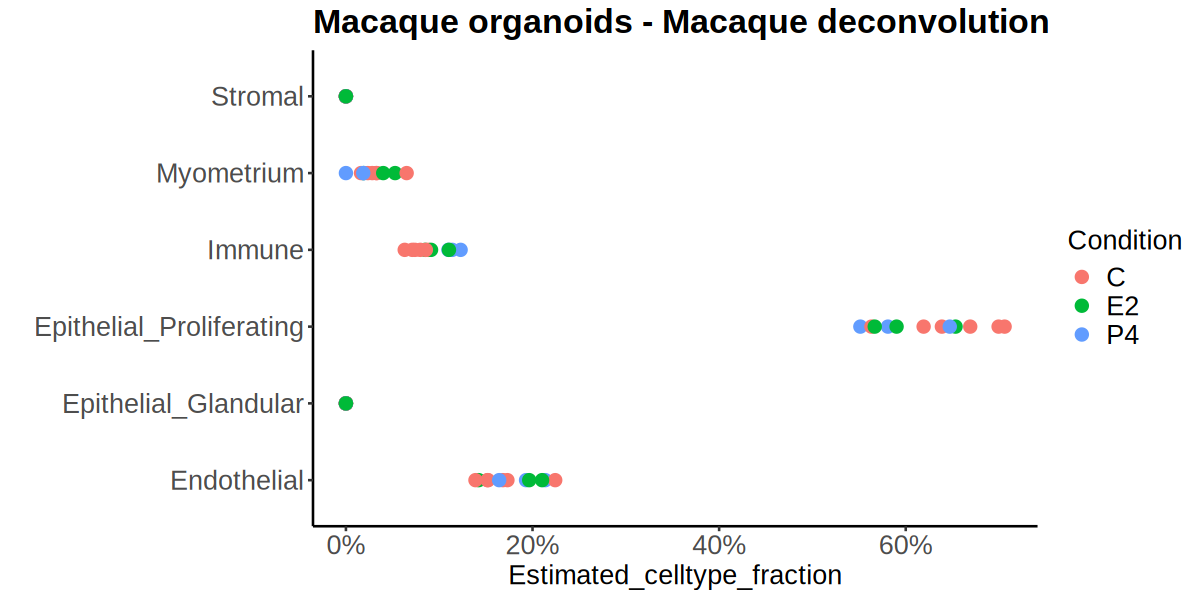

In [27]:
options(repr.plot.width=10, repr.plot.height=5)

## Plot by cell type

ggplot(DWLS_long, aes(x = Estimated_celltype_fraction, y = Celltypes, color = Condition))  +
      geom_point(size = 3) +
      scale_x_continuous(labels = scales::percent) +
      labs(y="") + 
      theme_classic(base_size = 12) +
    theme(plot.title = element_text(size = 20, face = "bold"), 
          axis.title = element_text(size = 16),
          axis.text =  element_text(size = 16),
          legend.text = element_text(size = 16),
          legend.title = element_text(size = 16)
                 ) +
    ggtitle("Macaque organoids - Macaque deconvolution")


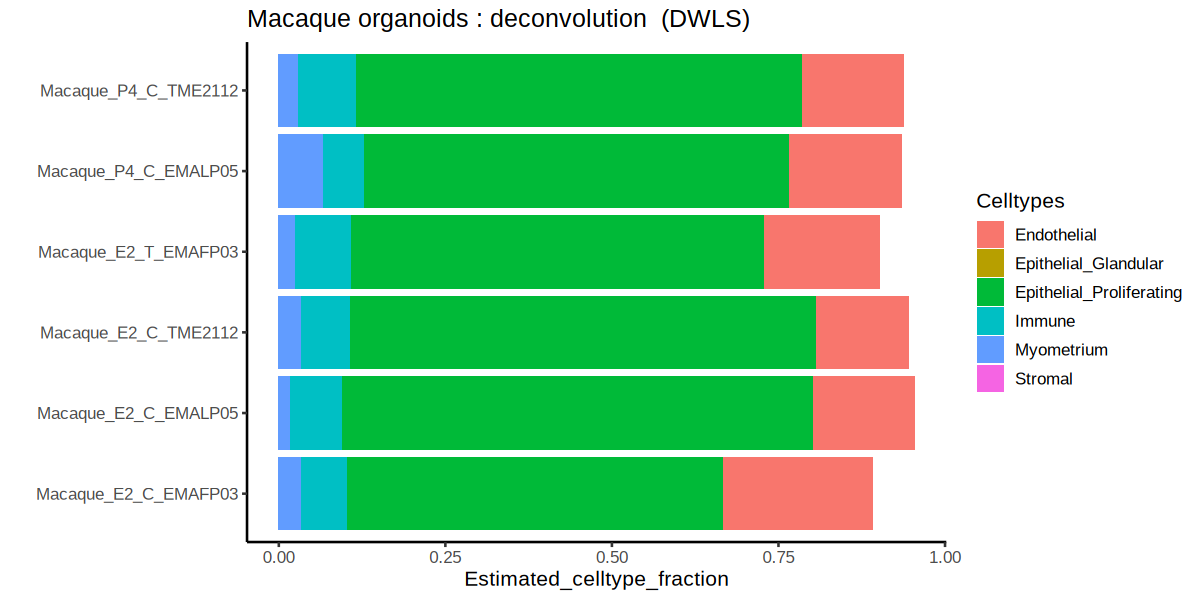

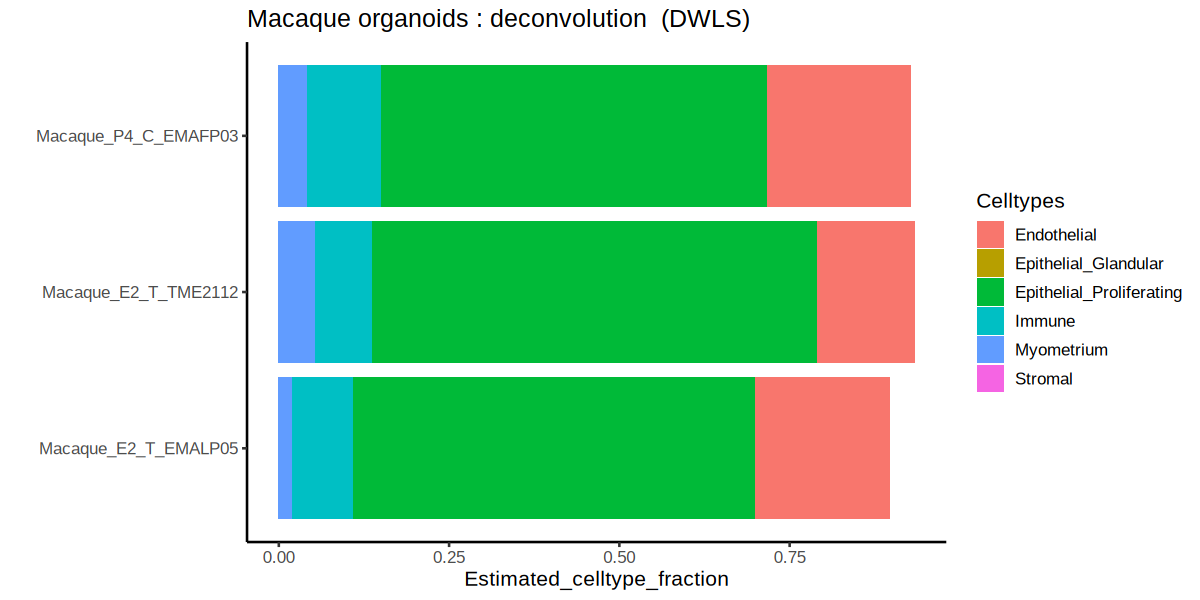

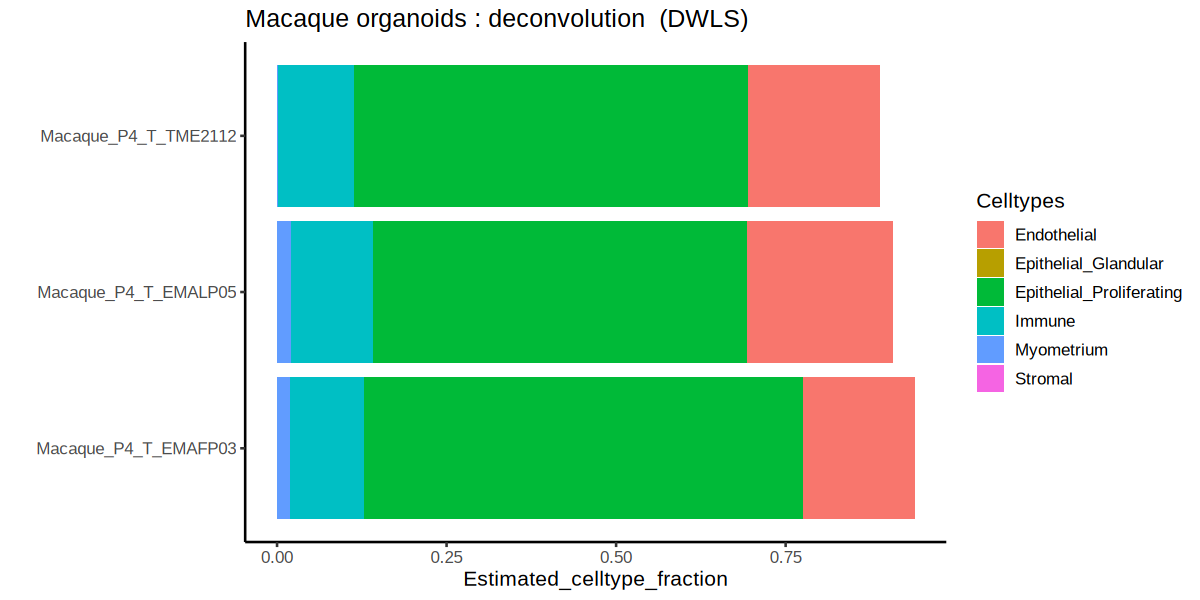

In [28]:
## Barplot per organoid with Mouse deconvolution

ggplot(DWLS_long %>% filter(Condition == "C"), aes(x = Estimated_celltype_fraction, y = LongName, fill = Celltypes)) +
    geom_bar(position="stack", stat="identity") +
    labs(y="") + 
      theme_classic(base_size = 12) +
    ggtitle("Macaque organoids : deconvolution  (DWLS)")

ggplot(DWLS_long %>% filter(Condition == "E2"), aes(x = Estimated_celltype_fraction, y = LongName, fill = Celltypes)) +
    geom_bar(position="stack", stat="identity") +
    labs(y="") + 
      theme_classic(base_size = 12) +
    ggtitle("Macaque organoids : deconvolution  (DWLS)")

ggplot(DWLS_long %>% filter(Condition == "P4"), aes(x = Estimated_celltype_fraction, y = LongName, fill = Celltypes)) +
    geom_bar(position="stack", stat="identity") +
    labs(y="") + 
      theme_classic(base_size = 12) +
    ggtitle("Macaque organoids : deconvolution  (DWLS)")

# Deconvolution of Macaque organoids with the Human dataset 

## Step 1 : Load single single-nuclei signatures

In [2]:
## Read the signature file for Mouse Pseudopregnant 
species = "Human"
load(paste0("../../../results/snRNA-seq/DWLS_", species,"/DWLS_", species,".RData"))

In [3]:
head(Signature)

SOX9_functional_basal dStromal   eStromal   Epithelial_MUC5B
AC024084.1 0.7781227             0.01830230 0.06926101 0.01283915      
KMO        1.2287919             0.05605953 0.22590091 0.02202896      
LINC02814  1.4655983             0.13528211 0.13647951 0.36843931      
AC078845.1 1.1024451             0.06375251 0.19961558 0.02459325      
CNTN5      1.5927252             0.14438764 0.11114270 0.03958386      
LINC02523  0.5978341             0.01118240 0.01342504 0.00471733      
           Epithelial_Cycling Immune_Lymphoid eStromal_cycling Immune_Myeloid
AC024084.1 0.6794569          0.12445781      0.06956871       0.19223706    
KMO        0.7508894          0.12814899      0.25134875       0.46346518    
LINC02814  1.1989231          0.15424784      0.12879807       0.17165157    
AC078845.1 0.9469471          0.23485159      0.18737995       0.27803414    
CNTN5      1.3515298          0.27442574      0.12465595       0.21521653    
LINC02523  0.6552117          0.04436438      0.01416109       0.04583754    
           Epithelial_Luminal Endothelial Glandular_secretory
AC024084.1 0.1883362          0.06440940  0.07094808         
KMO        0.2730145          0.15483010  0.13188134         
LINC02814  0.7029384          0.16238595  1.09879196         
AC078845.1 0.3273141          0.15635993  0.13930671         
CNTN5      1.6023891          0.16649460  1.21108490         
LINC02523  0.5529269          0.03000931  0.07601162         
           Epithelial_Ciliated eStromal_MMPs ePV       
AC024084.1 0.2482954           0.022267572   0.04169437
KMO        0.4401116           0.043581403   0.19065552
LINC02814  0.7013016           0.027021013   0.10739031
AC078845.1 0.4232704           0.047603945   0.14949034
CNTN5      0.7043499           0.065360858   0.12604070
LINC02523  0.3439166           0.004268684   0.01489540

### Hormonise gene symbols and gene ID for the bulk expression matrix using Ensembl gene annotation 

In [49]:
Gene_annotation = fread("../../../data/One2one_orthologues_HumanMouseMacaque.txt")
head(Gene_annotation)

### Add col for GeneID
Signature_ENSID = Signature %>% as.data.frame() %>% mutate("Human_genename" = row.names(Signature))

### Add col for ENSID
Signature_ENSID = left_join(Signature_ENSID, Gene_annotation, by = "Human_genename")
nrow(Signature_ENSID)
### Select only orthologs
Signature_ENSID = Signature_ENSID %>% filter(`Macaque_geneID` != "NA")
nrow(Signature_ENSID)

### Change rownames to ENSID
row.names(Signature_ENSID) = Signature_ENSID$Macaque_geneID
Signature_ENSID = Signature_ENSID %>% select(-"Human_genename", -"Human_geneID", -"Mouse_geneID", -"Mouse_genename",-"Macaque_geneID",-"Macaque_genename"  )
head(Signature_ENSID)

### Remove epithelial MUC5B cells as they come from cervical epithelium 
Signature_ENSID = Signature_ENSID %>% select(-Epithelial_MUC5B)

### Save this signature with ENSID
write.table(Signature_ENSID, file = paste0("../../../results/snRNA-seq/DWLS_", species,"/DWLS_Humansn_Signature_", species,".tsv"))
Signature_ENSID = as.matrix(Signature_ENSID)

Human_geneID    Human_genename Mouse_geneID       Mouse_genename
1 ENSG00000198763 MT-ND2         ENSMUSG00000064345 mt-Nd2        
2 ENSG00000198804 MT-CO1         ENSMUSG00000064351 mt-Co1        
3 ENSG00000198712 MT-CO2         ENSMUSG00000064354 mt-Co2        
4 ENSG00000228253 MT-ATP8        ENSMUSG00000064356 mt-Atp8       
5 ENSG00000198899 MT-ATP6        ENSMUSG00000064357 mt-Atp6       
6 ENSG00000198938 MT-CO3         ENSMUSG00000064358 mt-Co3        
  Macaque_geneID     Macaque_genename
1 ENSMFAG00000050431 ND2             
2 ENSMFAG00000060073 COX1            
3 ENSMFAG00000055785 COX2            
4 ENSMFAG00000048226 ATP8            
5 ENSMFAG00000053176 ATP6            
6 ENSMFAG00000060632 COX3

[1] 672

[1] 474

SOX9_functional_basal dStromal   eStromal  Epithelial_MUC5B
ENSMFAG00000044420 1.2287919             0.05605953 0.2259009 0.02202896      
ENSMFAG00000045865 1.5927252             0.14438764 0.1111427 0.03958386      
ENSMFAG00000031991 0.9865463             0.03442984 0.1201486 0.33957442      
ENSMFAG00000034433 0.7998096             0.04323011 0.1185284 0.21489572      
ENSMFAG00000045140 0.7774420             0.14429950 0.1150946 0.48629386      
ENSMFAG00000000094 0.8989668             0.07686004 0.1102610 0.16493190      
                   Epithelial_Cycling Immune_Lymphoid eStromal_cycling
ENSMFAG00000044420 0.7508894          0.12814899      0.2513488       
ENSMFAG00000045865 1.3515298          0.27442574      0.1246559       
ENSMFAG00000031991 0.8748155          0.11520565      0.1156842       
ENSMFAG00000034433 0.5313568          0.09919751      0.1184197       
ENSMFAG00000045140 0.6092876          0.07073196      0.1706824       
ENSMFAG00000000094 0.9793534          0.12049275      0.1154995       
                   Immune_Myeloid Epithelial_Luminal Endothelial
ENSMFAG00000044420 0.4634652      0.2730145          0.15483010 
ENSMFAG00000045865 0.2152165      1.6023891          0.16649460 
ENSMFAG00000031991 0.1356678      0.1262767          1.49527030 
ENSMFAG00000034433 0.1150765      0.2378994          0.24430419 
ENSMFAG00000045140 0.1141622      0.2842466          0.06163138 
ENSMFAG00000000094 0.1507543      0.6439681          0.19894093 
                   Glandular_secretory Epithelial_Ciliated eStromal_MMPs
ENSMFAG00000044420 0.13188134          0.4401116           0.04358140   
ENSMFAG00000045865 1.21108490          0.7043499           0.06536086   
ENSMFAG00000031991 0.19279242          0.2931681           0.15793309   
ENSMFAG00000034433 0.14793540          0.3026087           0.07634316   
ENSMFAG00000045140 0.06410913          0.2440322           0.02283641   
ENSMFAG00000000094 0.33411767          0.4707158           0.05937859   
                   ePV      
ENSMFAG00000044420 0.1906555
ENSMFAG00000045865 0.1260407
ENSMFAG00000031991 0.1263872
ENSMFAG00000034433 0.7703495
ENSMFAG00000045140 0.3333798
ENSMFAG00000000094 0.1840523

## Step 2 : Bulk RNAseq data 

The bulk RNA seq data must have Gene names or ENS ID matching the genes ID from the single-nuclei data. 
Data must be normalised before using it for deconvolution (CPM - or other normalisation). 

Here we use RPKM normalised data

In [50]:
nrow(Signature_ENSID)

[1] 474

In [51]:
species = "Macaque"

COUNTS = read.csv(paste0("../../../results/RNA-seq/countmatrix_normalised/", species,"_organoid_countmatrix_batchCorrected_logRPKM.tsv"),header=T,sep = "\t",row.names=1)

In [52]:
head(COUNTS)


TME2112.M.E2.T TME2112.M.E2.C TME2112.M.P4.T TME2112.M.P4.C
ENSMFAG00000000025 2.63681650     3.09419147     1.611239       2.74122550    
ENSMFAG00000000028 0.17006154     0.13426060     0.000000       0.02973256    
ENSMFAG00000000029 0.00000000     0.00000000     0.000000       0.00000000    
ENSMFAG00000000034 0.09358873     0.05545405     0.000000       0.20237823    
ENSMFAG00000000036 2.79741075     1.02316695     2.264508       1.16867978    
ENSMFAG00000000037 5.48744562     5.72327487     5.833698       5.52045461    
                   EMALP05.M.E2.T EMALP05.M.E2.C EMALP05.M.P4.T EMALP05.M.P4.C
ENSMFAG00000000025 3.1264504      2.785624       1.73091483     2.368031      
ENSMFAG00000000028 0.0000000      0.000000       0.07945945     0.000000      
ENSMFAG00000000029 0.0714076      0.000000       0.19096231     0.297786      
ENSMFAG00000000034 0.0000000      0.000000       0.19610233     0.000000      
ENSMFAG00000000036 2.5688411      1.206488       2.61516998     0.967114      
ENSMFAG00000000037 5.7090000      5.448706       5.70465459     5.574571      
                   EMAFP03.M.E2.T EMAFP03.M.E2.C EMAFP03.M.P4.T EMAFP03.M.P4.C
ENSMFAG00000000025 3.16102762     2.89702249     1.88592759     2.13306830    
ENSMFAG00000000028 0.00000000     0.00000000     0.00000000     0.00000000    
ENSMFAG00000000029 0.03117891     0.01166967     0.22357334     0.17454856    
ENSMFAG00000000034 0.00000000     0.21517123     0.02160646     0.05777823    
ENSMFAG00000000036 1.43223497     0.88008610     2.26813010     2.82439585    
ENSMFAG00000000037 5.61577992     5.61175154     5.75954368     5.64135291

### Deconvolution 

In [53]:
### filters your counts for genes maintained in the Signature Matrix
nrow(COUNTS)
COUNTS.trim = COUNTS[rownames(Signature_ENSID),] 
nrow(COUNTS.trim)
COUNTS.trim = as.matrix(COUNTS.trim)
## 

[1] 23937

[1] 474

474 used for the signature of single nuclei cell populations. 

The bulk RNAseq is therefore restricted for the deconvolution analysis to those 1155 genes. 

In [54]:
### grabbing a vector of your subject names
samples = colnames(COUNTS.trim)
samples

[1] "TME2112.M.E2.T" "TME2112.M.E2.C" "TME2112.M.P4.T" "TME2112.M.P4.C"
 [5] "EMALP05.M.E2.T" "EMALP05.M.E2.C" "EMALP05.M.P4.T" "EMALP05.M.P4.C"
 [9] "EMAFP03.M.E2.T" "EMAFP03.M.E2.C" "EMAFP03.M.P4.T" "EMAFP03.M.P4.C"

In [55]:
### Initializing Results Data Frames for Each Algorithm that DWLS employs (DWLS being the superstar)
DWLS = data.frame()
SVR = data.frame()
OLS = data.frame()

In [56]:
### Computing Cell Fractions for Each Sample and Adding to Results Data Frames
for(sample in samples){
        bulk = COUNTS.trim[,sample]
        names(bulk) = rownames(COUNTS.trim)
        tr = trimData(Signature_ENSID,bulk)
        solDWLS = solveDampenedWLS(tr$sig,tr$bulk)
        solSVR = solveSVR(tr$sig,tr$bulk)
        solOLS = solveOLS(tr$sig,tr$bulk)
        DWLS = rbind(DWLS,solDWLS)
        SVR = rbind(SVR,solSVR)
        OLS = rbind(OLS,solOLS)
}


SOX9_functional_basal              dStromal              eStromal 
              0.00000               0.00000               0.00000 
   Epithelial_Cycling       Immune_Lymphoid      eStromal_cycling 
              0.42039               0.00444               0.00010 
       Immune_Myeloid    Epithelial_Luminal           Endothelial 
              0.02500               0.17650               0.06288 
  Glandular_secretory   Epithelial_Ciliated         eStromal_MMPs 
              0.18245               0.02850               0.09068 
                  ePV 
              0.00906 
SOX9_functional_basal              dStromal              eStromal 
              0.00000               0.00000               0.00000 
   Epithelial_Cycling       Immune_Lymphoid      eStromal_cycling 
              0.48768               0.00000               0.16682 
       Immune_Myeloid    Epithelial_Luminal           Endothelial 
              0.00000               0.00000               0.02335 
  Glandular_secr

In [57]:
# Adding the rownames and columns back to each dataframe in list

colnames(DWLS) = colnames(Signature_ENSID)
rownames(DWLS) = samples
head(DWLS)



SOX9_functional_basal dStromal      eStromal     
TME2112.M.E2.T -1.068244e-17         -4.950793e-21  2.361044e-17
TME2112.M.E2.C  2.020428e-17         -4.103848e-18  1.426110e-17
TME2112.M.P4.T -1.400184e-17         -3.795006e-20 -2.775780e-18
TME2112.M.P4.C -2.362614e-17         -6.583281e-19  3.194963e-17
EMALP05.M.E2.T  1.009150e-17         -8.420956e-19  3.608424e-17
EMALP05.M.E2.C -3.670046e-17          6.431524e-19 -1.018824e-17
               Epithelial_Cycling Immune_Lymphoid eStromal_cycling
TME2112.M.E2.T 0.4203896          4.443898e-03     9.633366e-05   
TME2112.M.E2.C 0.4878345          6.699811e-04     2.219403e-04   
TME2112.M.P4.T 0.2858483          1.579583e-02    -8.522184e-19   
TME2112.M.P4.C 0.4428295          2.339654e-03     1.492472e-04   
EMALP05.M.E2.T 0.4398908          1.083829e-02     4.789395e-05   
EMALP05.M.E2.C 0.4945481          5.618536e-06     1.453818e-04   
               Immune_Myeloid Epithelial_Luminal Endothelial
TME2112.M.E2.T 0.02500344     0.1765007          0.06287796 
TME2112.M.E2.C 0.02389158     0.1453336          0.06058267 
TME2112.M.P4.T 0.01464523     0.3363561          0.04316965 
TME2112.M.P4.C 0.02657126     0.1720083          0.04675247 
EMALP05.M.E2.T 0.02354462     0.1842111          0.03352328 
EMALP05.M.E2.C 0.01908127     0.1614309          0.05150965 
               Glandular_secretory Epithelial_Ciliated eStromal_MMPs
TME2112.M.E2.T 0.1824502           0.028499724         0.09067721   
TME2112.M.E2.C 0.1764112           0.011751732         0.09328158   
TME2112.M.P4.T 0.1725957           0.043559267         0.07330254   
TME2112.M.P4.C 0.1901690           0.017367173         0.10178155   
EMALP05.M.E2.T 0.1987488           0.032177573         0.07701770   
EMALP05.M.E2.C 0.1725958           0.009118384         0.09156493   
               ePV          
TME2112.M.E2.T  9.060900e-03
TME2112.M.E2.C  2.124386e-05
TME2112.M.P4.T  1.472748e-02
TME2112.M.P4.C  3.193610e-05
EMALP05.M.E2.T  2.906191e-19
EMALP05.M.E2.C -1.811156e-19

### Deconvolution results 

In [58]:
DWLS = DWLS %>% mutate(SampleWName = rownames(DWLS))

head(DWLS)

SOX9_functional_basal dStromal      eStromal     
TME2112.M.E2.T -1.068244e-17         -4.950793e-21  2.361044e-17
TME2112.M.E2.C  2.020428e-17         -4.103848e-18  1.426110e-17
TME2112.M.P4.T -1.400184e-17         -3.795006e-20 -2.775780e-18
TME2112.M.P4.C -2.362614e-17         -6.583281e-19  3.194963e-17
EMALP05.M.E2.T  1.009150e-17         -8.420956e-19  3.608424e-17
EMALP05.M.E2.C -3.670046e-17          6.431524e-19 -1.018824e-17
               Epithelial_Cycling Immune_Lymphoid eStromal_cycling
TME2112.M.E2.T 0.4203896          4.443898e-03     9.633366e-05   
TME2112.M.E2.C 0.4878345          6.699811e-04     2.219403e-04   
TME2112.M.P4.T 0.2858483          1.579583e-02    -8.522184e-19   
TME2112.M.P4.C 0.4428295          2.339654e-03     1.492472e-04   
EMALP05.M.E2.T 0.4398908          1.083829e-02     4.789395e-05   
EMALP05.M.E2.C 0.4945481          5.618536e-06     1.453818e-04   
               Immune_Myeloid Epithelial_Luminal Endothelial
TME2112.M.E2.T 0.02500344     0.1765007          0.06287796 
TME2112.M.E2.C 0.02389158     0.1453336          0.06058267 
TME2112.M.P4.T 0.01464523     0.3363561          0.04316965 
TME2112.M.P4.C 0.02657126     0.1720083          0.04675247 
EMALP05.M.E2.T 0.02354462     0.1842111          0.03352328 
EMALP05.M.E2.C 0.01908127     0.1614309          0.05150965 
               Glandular_secretory Epithelial_Ciliated eStromal_MMPs
TME2112.M.E2.T 0.1824502           0.028499724         0.09067721   
TME2112.M.E2.C 0.1764112           0.011751732         0.09328158   
TME2112.M.P4.T 0.1725957           0.043559267         0.07330254   
TME2112.M.P4.C 0.1901690           0.017367173         0.10178155   
EMALP05.M.E2.T 0.1987488           0.032177573         0.07701770   
EMALP05.M.E2.C 0.1725958           0.009118384         0.09156493   
               ePV           SampleWName   
TME2112.M.E2.T  9.060900e-03 TME2112.M.E2.T
TME2112.M.E2.C  2.124386e-05 TME2112.M.E2.C
TME2112.M.P4.T  1.472748e-02 TME2112.M.P4.T
TME2112.M.P4.C  3.193610e-05 TME2112.M.P4.C
EMALP05.M.E2.T  2.906191e-19 EMALP05.M.E2.T
EMALP05.M.E2.C -1.811156e-19 EMALP05.M.E2.C

In [59]:
## Add metadata to bulk estimates 
metadata = fread("../../../config/samplesheet.tsv")
head(metadata)
# ## Merge with deconvolution results 
DWLS_md = left_join(DWLS, metadata, by ="SampleWName")
head(DWLS_md)

SampleLabel  Species Hormone Treatment Condition Replicat LongName        
1 A1H7.H.E2.C  Human   E2      Control   C         Rep1     Human_E2_C_A1H7 
2 A7H8.H.E2.C  Human   E2      Control   C         Rep2     Human_E2_C_A7H8 
3 B1H8.H.E2.C  Human   E2      Control   C         Rep3     Human_E2_C_B1H8 
4 ws520.H.E2.C Human   E2      Control   C         Rep4     Human_E2_C_ws520
5 ws522.H.E2.C Human   E2      Control   C         Rep5     Human_E2_C_ws522
6 ws528.H.E2.C Human   E2      Control   C         Rep6     Human_E2_C_ws528
  ShortName SampleWName 
1 H_C_1     A1H7.H.E2.C 
2 H_C_2     A7H8.H.E2.C 
3 H_C_3     B1H8.H.E2.C 
4 H_C_4     ws520.H.E2.C
5 H_C_5     ws522.H.E2.C
6 H_C_6     ws528.H.E2.C

SOX9_functional_basal dStromal      eStromal      Epithelial_Cycling
1 -1.068244e-17         -4.950793e-21  2.361044e-17 0.4203896         
2  2.020428e-17         -4.103848e-18  1.426110e-17 0.4878345         
3 -1.400184e-17         -3.795006e-20 -2.775780e-18 0.2858483         
4 -2.362614e-17         -6.583281e-19  3.194963e-17 0.4428295         
5  1.009150e-17         -8.420956e-19  3.608424e-17 0.4398908         
6 -3.670046e-17          6.431524e-19 -1.018824e-17 0.4945481         
  Immune_Lymphoid eStromal_cycling Immune_Myeloid Epithelial_Luminal
1 4.443898e-03     9.633366e-05    0.02500344     0.1765007         
2 6.699811e-04     2.219403e-04    0.02389158     0.1453336         
3 1.579583e-02    -8.522184e-19    0.01464523     0.3363561         
4 2.339654e-03     1.492472e-04    0.02657126     0.1720083         
5 1.083829e-02     4.789395e-05    0.02354462     0.1842111         
6 5.618536e-06     1.453818e-04    0.01908127     0.1614309         
  Endothelial Glandular_secretory ⋯ ePV           SampleWName    SampleLabel   
1 0.06287796  0.1824502           ⋯  9.060900e-03 TME2112.M.E2.T TME2112.M.E2.T
2 0.06058267  0.1764112           ⋯  2.124386e-05 TME2112.M.E2.C TME2112.M.E2.C
3 0.04316965  0.1725957           ⋯  1.472748e-02 TME2112.M.P4.T TME2112.M.P4.T
4 0.04675247  0.1901690           ⋯  3.193610e-05 TME2112.M.P4.C TME2112.M.P4.C
5 0.03352328  0.1987488           ⋯  2.906191e-19 EMALP05.M.E2.T EMALP05.M.E2.T
6 0.05150965  0.1725958           ⋯ -1.811156e-19 EMALP05.M.E2.C EMALP05.M.E2.C
  Species Hormone Treatment Condition Replicat LongName             ShortName
1 Macaque E2      Treatment E2        Rep1     Macaque_E2_T_TME2112 M_E2_1   
2 Macaque E2      Control   C         Rep1     Macaque_E2_C_TME2112 M_C_1    
3 Macaque P4      Treatment P4        Rep1     Macaque_P4_T_TME2112 M_P4_1   
4 Macaque P4      Control   C         Rep1     Macaque_P4_C_TME2112 M_C_4    
5 Macaque E2      Treatment E2        Rep2     Macaque_E2_T_EMALP05 M_E2_2   
6 Macaque E2      Control   C         Rep2     Macaque_E2_C_EMALP05 M_C_2

In [60]:
## Fraction of endometrial cells predicted in bulk organoids
celltypes = c('SOX9_functional_basal','dStromal','eStromal','Epithelial_Cycling','Immune_Lymphoid','eStromal_cycling','Immune_Myeloid','Epithelial_Luminal','Endothelial','Glandular_secretory','Epithelial_Ciliated','eStromal_MMPs','ePV')
DWLS_long = DWLS_md %>% pivot_longer(cols = celltypes, names_to = "Celltypes", values_to = "Estimated_celltype_fraction")
head(DWLS_long)


SampleWName    SampleLabel    Species Hormone Treatment Condition Replicat
1 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
2 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
3 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
4 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
5 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
6 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
  LongName             ShortName Celltypes            
1 Macaque_E2_T_TME2112 M_E2_1    SOX9_functional_basal
2 Macaque_E2_T_TME2112 M_E2_1    dStromal             
3 Macaque_E2_T_TME2112 M_E2_1    eStromal             
4 Macaque_E2_T_TME2112 M_E2_1    Epithelial_Cycling   
5 Macaque_E2_T_TME2112 M_E2_1    Immune_Lymphoid      
6 Macaque_E2_T_TME2112 M_E2_1    eStromal_cycling     
  Estimated_celltype_fraction
1 -1.068244e-17              
2 -4.950793e-21              
3  2.361044e-17              
4  4.203896e-01              
5  4.443898e-03              
6  9.633366e-05

In [61]:
write.table(x = DWLS_long, file = paste0("../../../results/snRNA-seq/DWLS_",species,"/DWLS_", species, "Organoids_deconvolution_with_Humansn.tsv"), sep = "\t", row.names = F, quote = F)

## Results of deconvolution 

In [3]:
species = "Macaque"
DWLS_long = fread(input =  paste0("../../../results/snRNA-seq/DWLS_",species,"/DWLS_", species, "Organoids_deconvolution_with_Humansn.tsv"), sep = "\t")

## Order by % of cell types / and by Epithelial VS other celltypes
celltype_order = rev(c('Epithelial_Cycling','Epithelial_Luminal','Glandular_secretory','Epithelial_Ciliated', 'SOX9_functional_basal','dStromal','eStromal','eStromal_MMPs','eStromal_cycling','ePV','Endothelial','Immune_Lymphoid','Immune_Myeloid'))

DWLS_long$Celltypes = factor(DWLS_long$Celltypes, levels= celltype_order)


In [4]:
head(DWLS_long)

SampleWName    SampleLabel    Species Hormone Treatment Condition Replicat
1 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
2 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
3 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
4 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
5 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
6 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
  LongName             ShortName Celltypes            
1 Macaque_E2_T_TME2112 M_E2_1    SOX9_functional_basal
2 Macaque_E2_T_TME2112 M_E2_1    dStromal             
3 Macaque_E2_T_TME2112 M_E2_1    eStromal             
4 Macaque_E2_T_TME2112 M_E2_1    Epithelial_Cycling   
5 Macaque_E2_T_TME2112 M_E2_1    Immune_Lymphoid      
6 Macaque_E2_T_TME2112 M_E2_1    eStromal_cycling     
  Estimated_celltype_fraction
1 -1.068244e-17              
2 -4.950793e-21              
3  2.361044e-17              
4  4.203896e-01              
5  4.443898e-03              
6  9.633366e-05

In [117]:
options(repr.plot.width=8, repr.plot.height=5)

## Plot by cell type

ggplot(DWLS_long, aes(x = Estimated_celltype_fraction, y = Celltypes, color = Condition))  +
      geom_point(size = 3) +
      scale_x_continuous(labels = scales::percent) +
      scale_color_manual(values = c("grey","#ebd08a","#b55d5a")) +
      labs(y="", x="") + 
      theme_classic(base_size = 12) +
    theme(plot.title = element_text(size = 20, face = "bold"), 
          axis.title = element_text(size = 16),
          axis.text =  element_text(size = 16),
          legend.text = element_text(size = 16),
          legend.title = element_text(size = 16)
                 ) +
    ggtitle("Macaque organoids deconvolution")


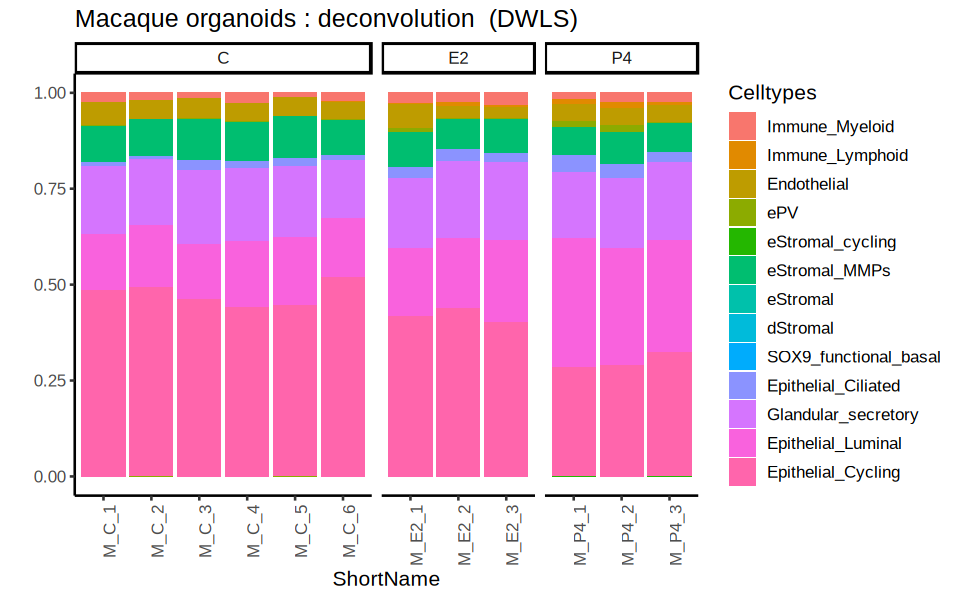

In [128]:
options(repr.plot.width=8, repr.plot.height=5)

## Plot barplor
ggplot(DWLS_long, aes(x =ShortName , y = Estimated_celltype_fraction, fill = Celltypes)) +
    geom_bar(position="stack", stat="identity") +
    labs(y="") + 
    theme_classic(base_size = 12) + theme(axis.text.x = element_text(angle = 90)) +
    ggtitle("Macaque organoids : deconvolution  (DWLS)") +
    facet_nested(~Condition, scales = "free", space = "free")


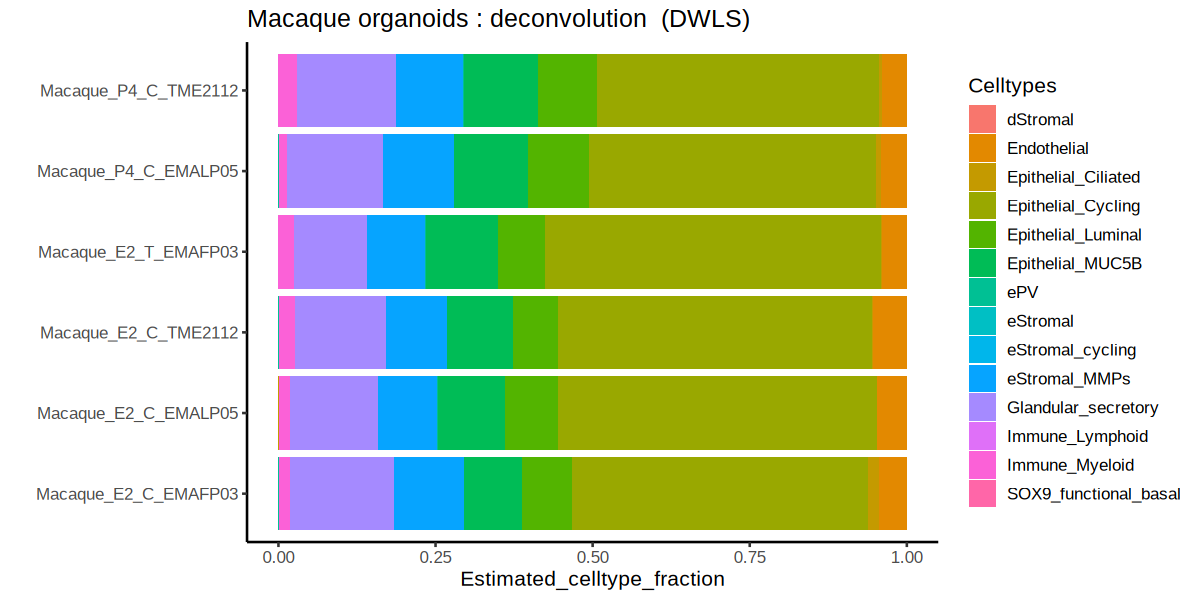

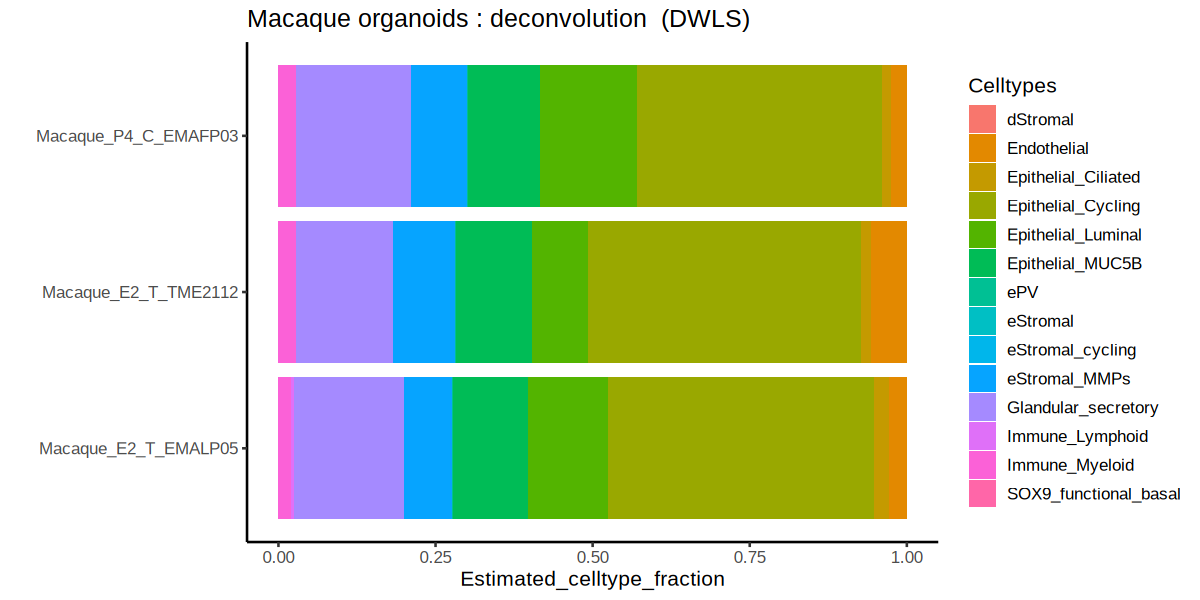

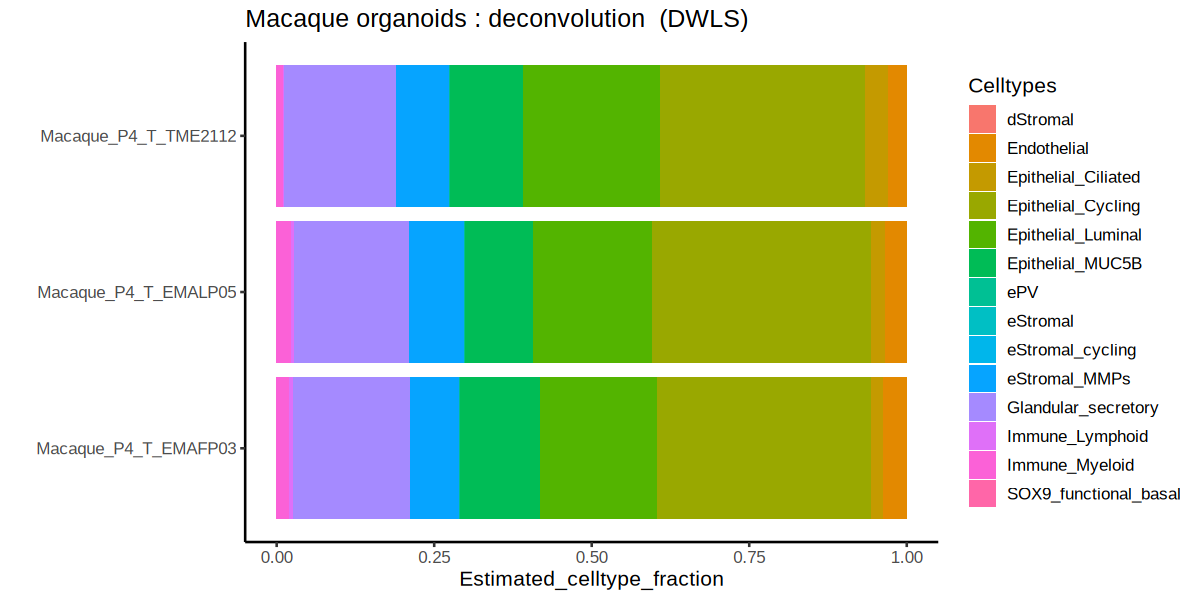

In [33]:
## Barplot per organoid

ggplot(DWLS_long %>% filter(Condition == "C"), aes(x = Estimated_celltype_fraction, y = LongName, fill = Celltypes)) +
    geom_bar(position="stack", stat="identity") +
    labs(y="") + 
      theme_classic(base_size = 12) +
    ggtitle("Macaque organoids : deconvolution  (DWLS)")

ggplot(DWLS_long %>% filter(Condition == "E2"), aes(x = Estimated_celltype_fraction, y = LongName, fill = Celltypes)) +
    geom_bar(position="stack", stat="identity") +
    labs(y="") + 
      theme_classic(base_size = 12) +
    ggtitle("Macaque organoids : deconvolution  (DWLS)")

ggplot(DWLS_long %>% filter(Condition == "P4"), aes(x = Estimated_celltype_fraction, y = LongName, fill = Celltypes)) +
    geom_bar(position="stack", stat="identity") +
    labs(y="") + 
      theme_classic(base_size = 12) +
    ggtitle("Macaque organoids : deconvolution  (DWLS)")

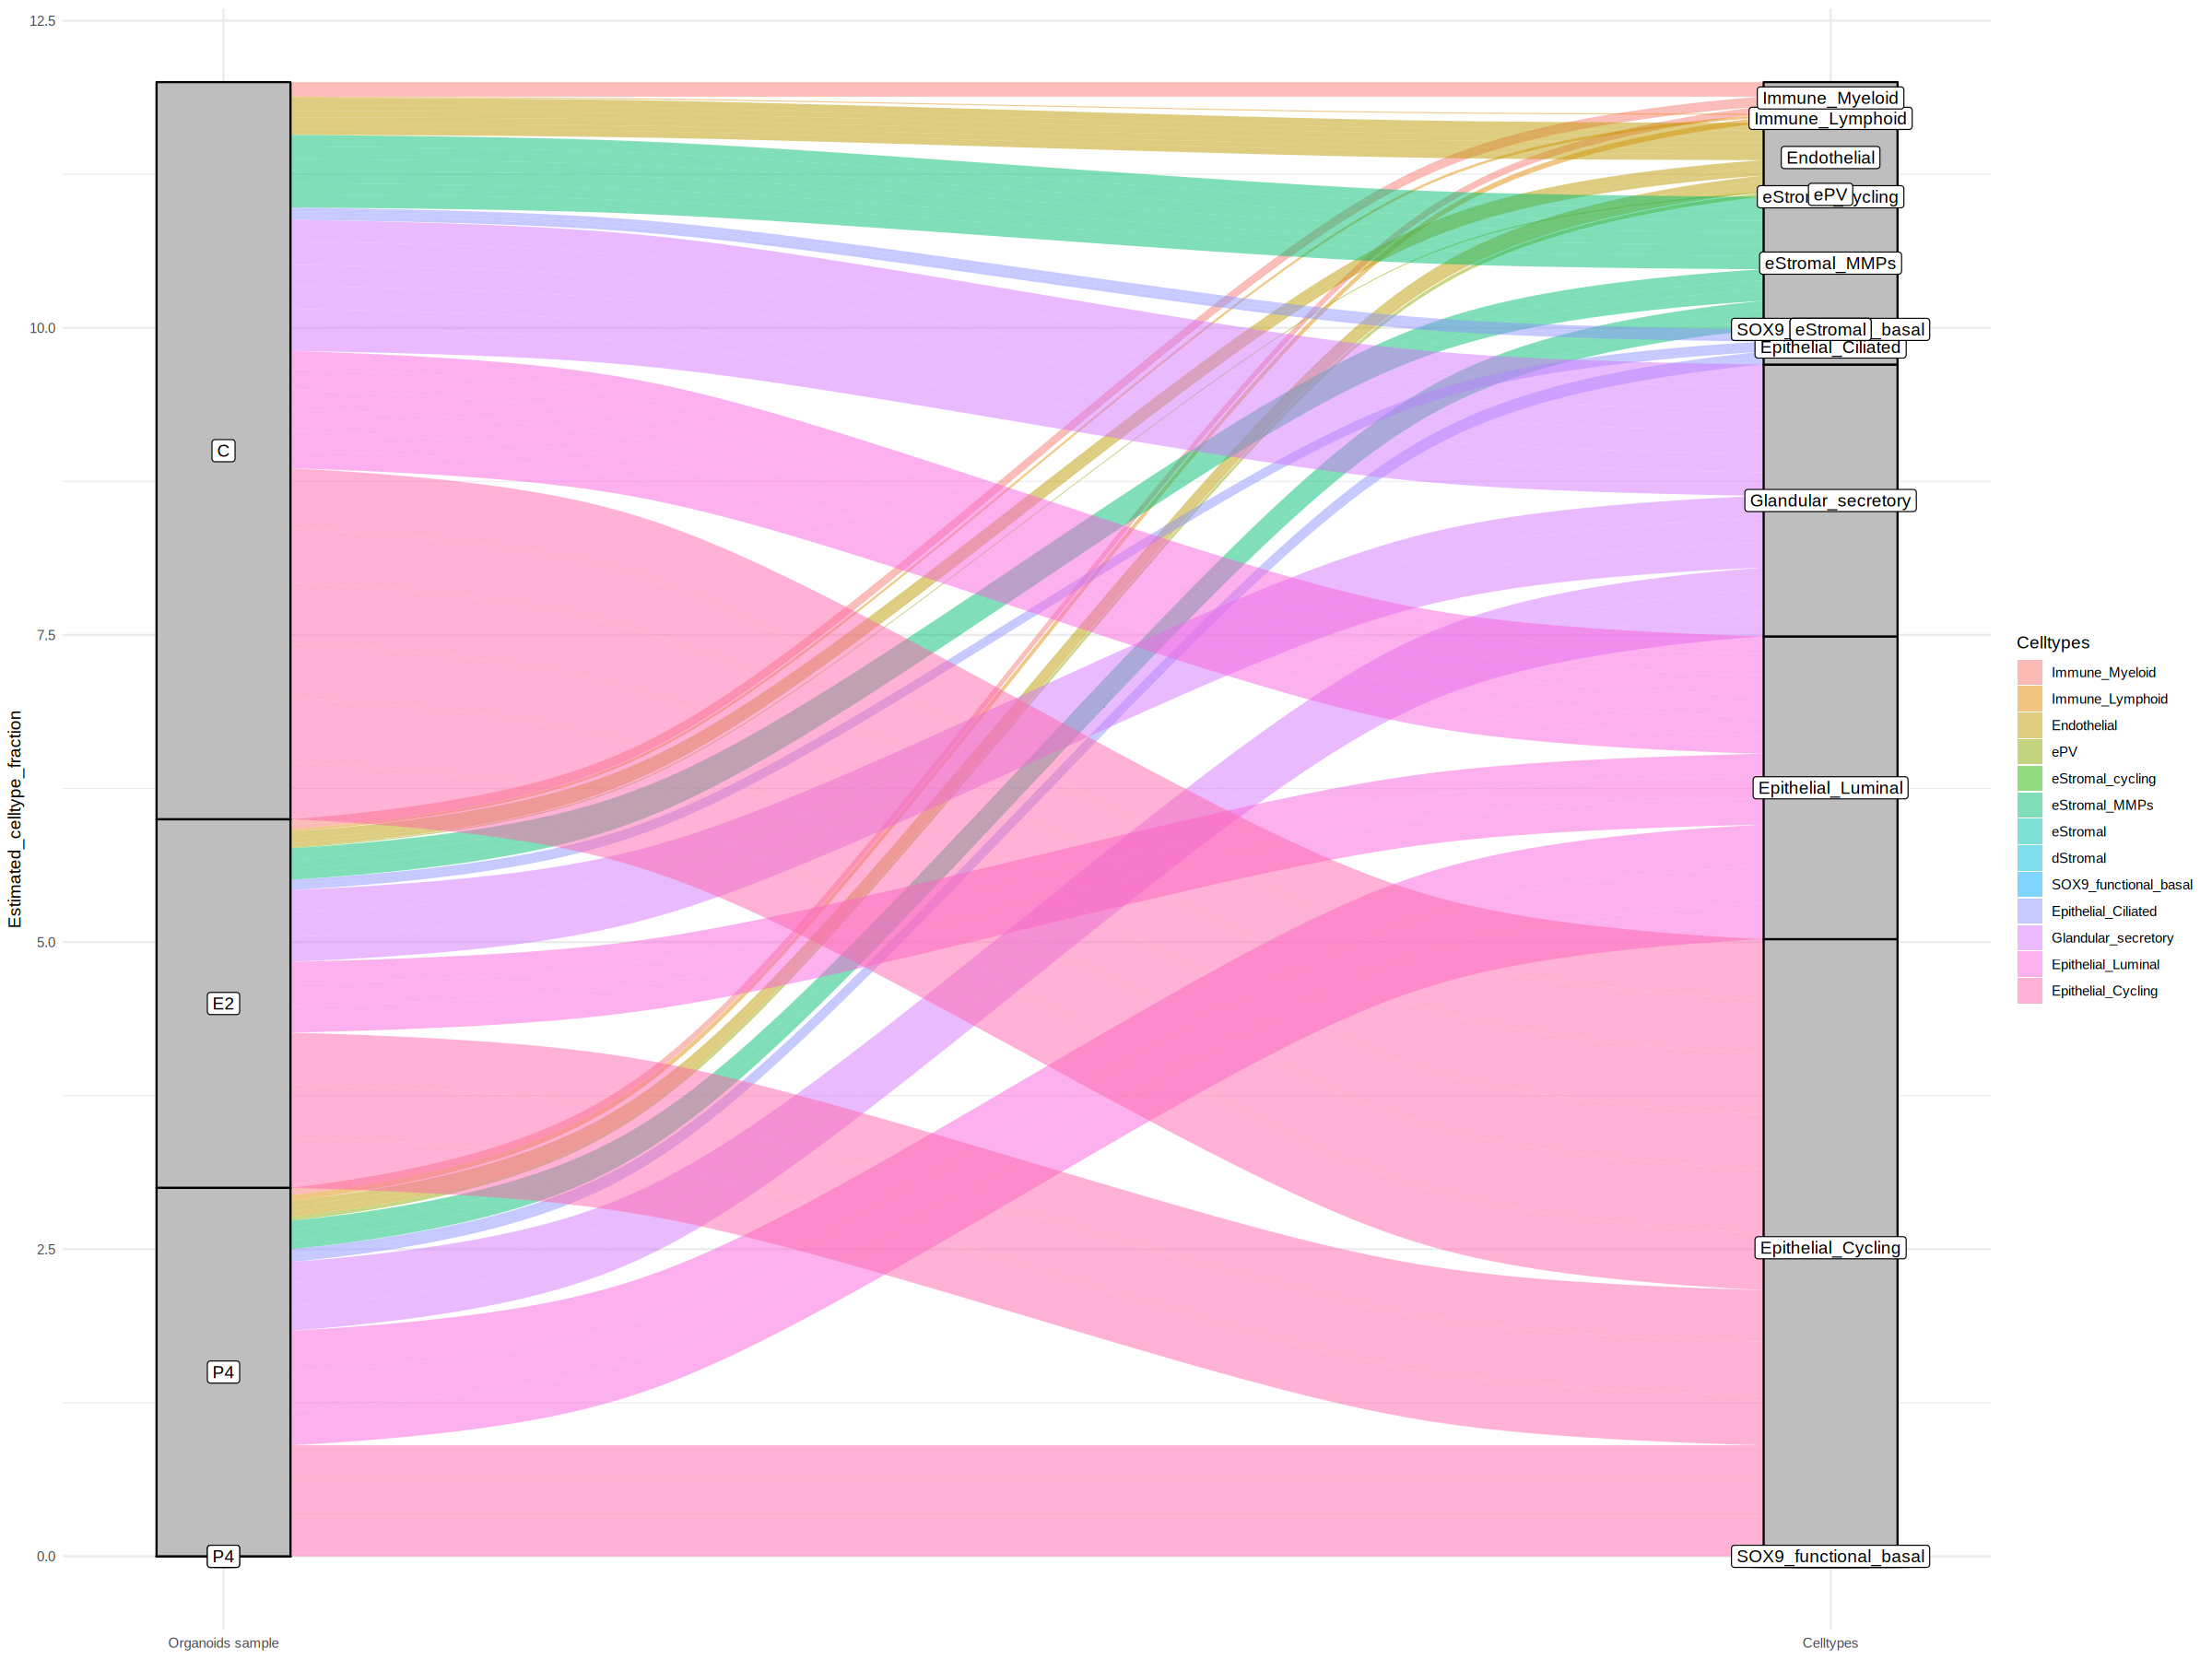

In [122]:
options(repr.plot.width=20, repr.plot.height=15)

ggplot(as.data.frame(DWLS_long),
       aes(y= Estimated_celltype_fraction, axis1 = Condition,, axis2=Celltypes)) +
  geom_alluvium(aes(fill = Celltypes), width = 1/12) +
  geom_stratum(width = 1/12, fill = "grey", color = "black") +
  geom_label(stat = "stratum", aes(label = after_stat(stratum))) +
  scale_x_discrete(limits = c("Organoids sample", "Celltypes"), expand = c(.05, .05)) +
theme_minimal() 
#   scale_fill_brewer(type = "qual", palette = "Set2")

SampleWName    SampleLabel    Species Hormone Treatment Condition Replicat
1 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
2 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
3 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
4 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
5 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
6 TME2112.M.E2.T TME2112.M.E2.T Macaque E2      Treatment E2        Rep1    
  LongName             ShortName Celltypes            
1 Macaque_E2_T_TME2112 M_E2_1    SOX9_functional_basal
2 Macaque_E2_T_TME2112 M_E2_1    dStromal             
3 Macaque_E2_T_TME2112 M_E2_1    eStromal             
4 Macaque_E2_T_TME2112 M_E2_1    Epithelial_Cycling   
5 Macaque_E2_T_TME2112 M_E2_1    Immune_Lymphoid      
6 Macaque_E2_T_TME2112 M_E2_1    eStromal_cycling     
  Estimated_celltype_fraction
1 -1.068244e-17              
2 -4.950793e-21              
3  2.361044e-17              
4  4.203896e-01              
5  4.443898e-03              
6  9.633366e-05

`summarise()` has grouped output by 'Condition'. You can override using the
`.groups` argument.


Condition Celltypes        Estimated_celltype_fraction_mean
1 C         Immune_Myeloid   1.969206e-02                    
2 C         Immune_Lymphoid  1.415084e-03                    
3 C         Endothelial      5.051454e-02                    
4 C         ePV              8.863327e-06                    
5 C         eStromal_cycling 1.705871e-04                    
6 C         eStromal_MMPs    9.829435e-02

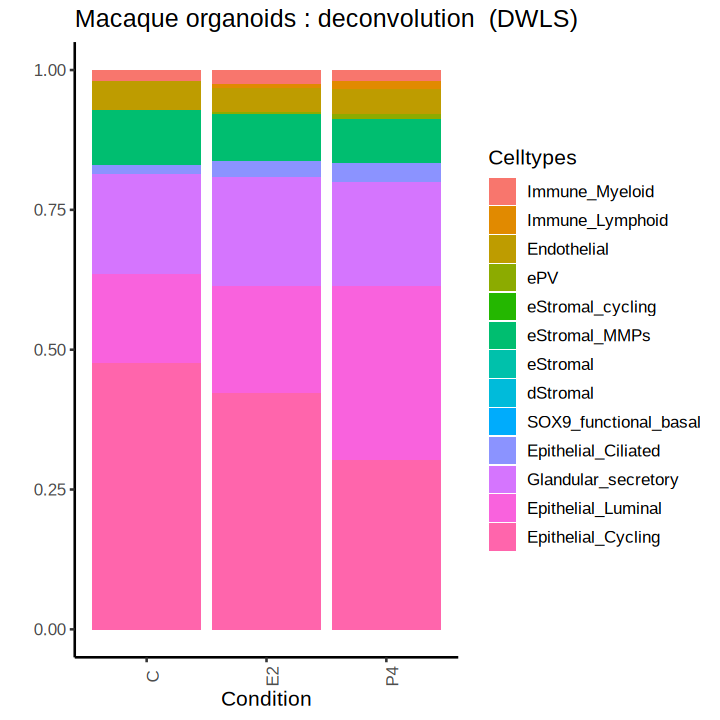

In [5]:
## Spred cell types by conditions 
head(DWLS_long)
DWLS_verylong = DWLS_long %>% select(Condition,Species,Replicat, Celltypes, Estimated_celltype_fraction) %>% 
    group_by(Condition, Celltypes) %>% summarize(Estimated_celltype_fraction_mean = mean(Estimated_celltype_fraction)) 
#     pivot_wider(names_from = Condition, values_from = Estimated_celltype_fraction_mean)
head(DWLS_verylong)

options(repr.plot.width=6, repr.plot.height=6)

## Plot barplor
ggplot(DWLS_verylong, aes(x =Condition , y = Estimated_celltype_fraction_mean, fill = Celltypes)) +
    geom_bar(position="stack", stat="identity") +
    labs(y="") + 
    theme_classic(base_size = 12) + theme(axis.text.x = element_text(angle = 90)) +
    ggtitle("Macaque organoids : deconvolution  (DWLS)")


In [6]:
DWLS_verylong

Condition Celltypes             Estimated_celltype_fraction_mean
1  C         Immune_Myeloid         1.969206e-02                   
2  C         Immune_Lymphoid        1.415084e-03                   
3  C         Endothelial            5.051454e-02                   
4  C         ePV                    8.863327e-06                   
5  C         eStromal_cycling       1.705871e-04                   
6  C         eStromal_MMPs          9.829435e-02                   
7  C         eStromal               5.472184e-18                   
8  C         dStromal              -1.618382e-20                   
9  C         SOX9_functional_basal -8.827196e-18                   
10 C         Epithelial_Ciliated    1.655665e-02                   
11 C         Glandular_secretory    1.780472e-01                   
12 C         Epithelial_Luminal     1.591973e-01                   
13 C         Epithelial_Cycling     4.761033e-01                   
14 E2        Immune_Myeloid         2.655367e-02                   
15 E2        Immune_Lymphoid        7.143929e-03                   
16 E2        Endothelial            4.191400e-02                   
17 E2        ePV                    3.020300e-03                   
18 E2        eStromal_cycling       5.195839e-05                   
19 E2        eStromal_MMPs          8.557727e-02                   
20 E2        eStromal               2.634484e-17                   
21 E2        dStromal              -1.718412e-18                   
22 E2        SOX9_functional_basal -3.534253e-18                   
23 E2        Epithelial_Ciliated    2.774536e-02                   
24 E2        Glandular_secretory    1.947987e-01                   
25 E2        Epithelial_Luminal     1.921628e-01                   
26 E2        Epithelial_Cycling     4.210321e-01                   
27 P4        Immune_Myeloid         1.989570e-02                   
28 P4        Immune_Lymphoid        1.499667e-02                   
29 P4        Endothelial            4.451484e-02                   
30 P4        ePV                    9.570894e-03                   
31 P4        eStromal_cycling      -1.402475e-18                   
32 P4        eStromal_MMPs          7.749001e-02                   
33 P4        eStromal               2.044228e-18                   
34 P4        dStromal              -6.123095e-20                   
35 P4        SOX9_functional_basal -1.293018e-17                   
36 P4        Epithelial_Ciliated    3.462351e-02                   
37 P4        Glandular_secretory    1.867112e-01                   
38 P4        Epithelial_Luminal     3.108462e-01                   
39 P4        Epithelial_Cycling     3.013510e-01

In [163]:
sessionInfo()

R version 4.3.0 (2023-04-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.8 (Ootpa)

Matrix products: default
BLAS/LAPACK: /opt/gensoft/lib/OpenBLAS/0.3.21/lib/libopenblas_zenp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.9.3       forcats_1.0.0         readr_2.1.5          
 [4] tidyr_1.3.1           tibble_3.2.1          tidyverse_2.0.0      
 [7] edgeR_4.0.16          limma_3.58.1          Seurat_5.0.1       